# **Big Project -- The Product Pricer**

## **1️⃣Step 1 : Import & Call API**

In [223]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from openai import OpenAI
import pandas as pd
pd.set_option('display.width', 1000)                      # 调整显示宽度（表示每行最多显示 1000 个字符）

In [224]:
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
deepseek_api_key = os.getenv('DEEPSEEK_API_KEY')
hf_api_key = os.getenv('HF-Write')
oai_client = OpenAI()
ds_client = OpenAI(api_key=deepseek_api_key, base_url="https://api.deepseek.com")
login(hf_api_key, add_to_git_credential=True)

In [3]:
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
deepseek_api_key = os.getenv('DEEPSEEK_API_KEY')
hf_api_key = os.getenv('HF-Write')

In [4]:
oai_client = OpenAI()
ds_client = OpenAI(api_key=deepseek_api_key, base_url="https://api.deepseek.com")

**Login to Hugging Face to download dataset**

In [5]:
login(hf_api_key, add_to_git_credential=True)

## **2️⃣Step 2 : Download Datset From Hugging Face**

### **Download only Appliances data first -- for a Simple understanding**

In [6]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Appliances", split="full", trust_remote_code=True)

**Tips: ```{len(dataset):,}``` 这里的 ```,``` 会使输出结果有，隔开**

In [18]:
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


**Tips: ```print(dataset[0])``` 直接打印了一个字典，Python 默认将字典的字符串表示压缩为单行。要让输出更清晰、多行显示，可以使用以下方法：**

In [19]:
from pprint import pprint
dataset[0]

{'main_category': 'Industrial & Scientific',
 'title': 'ROVSUN Ice Maker Machine Countertop, Make 44lbs Ice in 24 Hours, Compact & Portable Ice Maker with Ice Basket for Home, Office, Kitchen, Bar (Silver)',
 'average_rating': 3.7,
 'rating_number': 61,
 'features': ['【Quick Ice Making】This countertop ice machine creates crystal & bullet shaped ice cubes; 44lbs of ice ready in 24 hours, 12 cubes made per cycle within 10 mins; you can perfectly use it for drinks, wine, smoothies, food',
  '【Portable Design】The weight of this ice maker is only 23.3lbs, and the small size (10.63 x14.37 x 12.87)" makes it portable. It\'s compact feature is perfect for home, office, apartments, dormitories, RVs and more, it can be placed on countertop or tabletop, plug it anywhere you like',
  '【Simple Operation】Adding the water tank with purified water; Power on machine and press "on/off" button to start ice making process; After 8-12 minutes, ice cube will fall off into the ice basket automatically; Take 

In [29]:
list(dataset[0].keys())

['main_category',
 'title',
 'average_rating',
 'rating_number',
 'features',
 'description',
 'price',
 'images',
 'videos',
 'store',
 'categories',
 'details',
 'parent_asin',
 'bought_together',
 'subtitle',
 'author']

In [20]:
# How many have prices?

prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


In [21]:
# For those with prices, gather the price and the length

prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

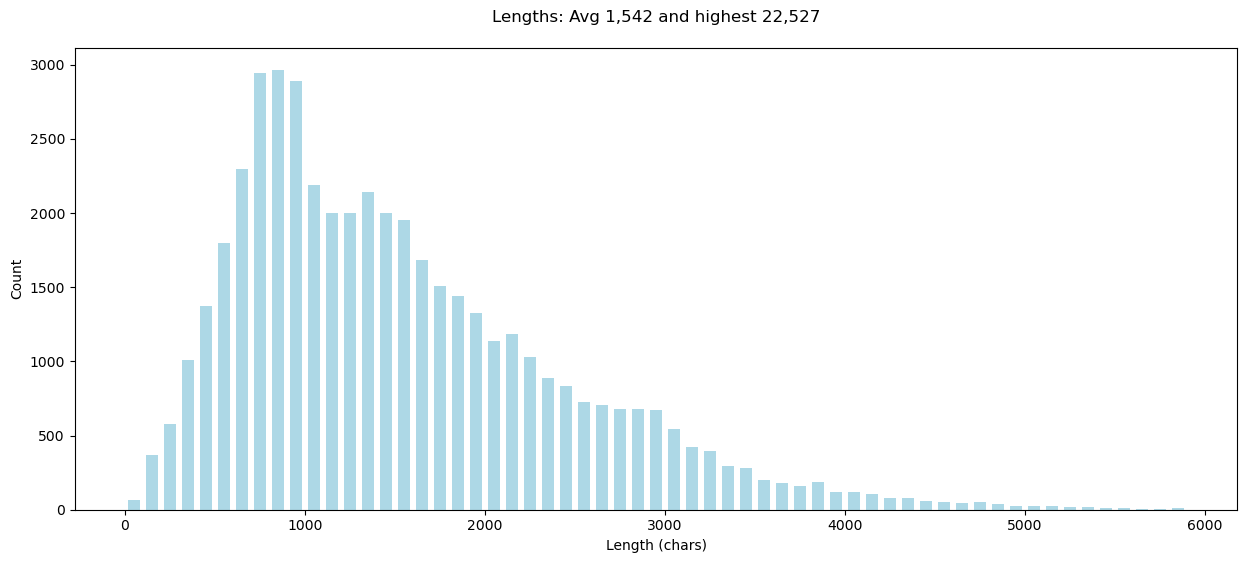

In [22]:
# Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

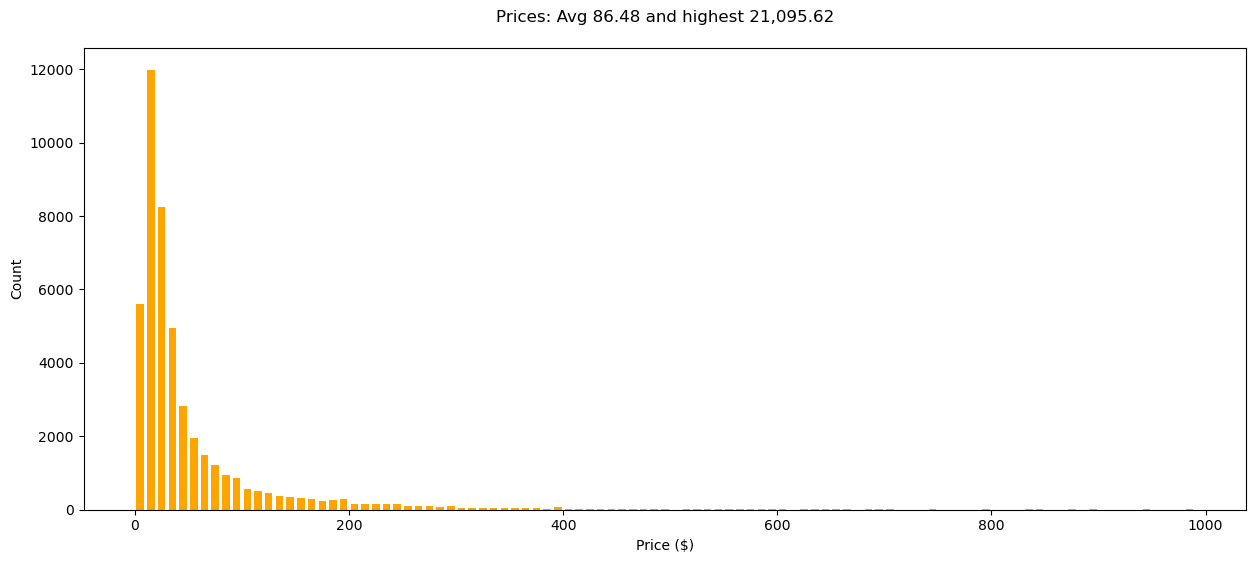

In [24]:
# Plot the distribution of prices

plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [25]:
# So what is this item??

for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 21000:
            print(datapoint['title'])
    except ValueError as e:
        pass

TurboChef BULLET Rapid Cook Electric Microwave Convection Oven


### **Doowload full dataset & Text Cleaning + Data Filtering with Class**

ItemLoader 类的作用是加载和处理 Amazon Reviews 2023 数据集中的产品数据，生成符合条件的 Item 对象列表

In [30]:
import sys
sys.path.append(r'C:\Users\zekin\projects\llm_engineering\week6')  
from loaders import ItemLoader  

In [31]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games", 
    "Appliances",
    "Musical_Instruments",
]

In [48]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Automotive


meta_Automotive.jsonl:  14%|#4        | 755M/5.35G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs-us-1.hf.co/repos/e9/40/e940a8d106b2e3986d1f8b7626c5a3f4fced3c1f43b992d12b1d465b58efc824/8399c5ab84b2a5239e105974a33fb5d1d6d5e1e643291713008c096240ef6941?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27meta_Automotive.jsonl%3B+filename%3D%22meta_Automotive.jsonl%22%3B&Expires=1742784095&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0Mjc4NDA5NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2U5LzQwL2U5NDBhOGQxMDZiMmUzOTg2ZDFmOGI3NjI2YzVhM2Y0ZmNlZDNjMWY0M2I5OTJkMTJiMWQ0NjViNThlZmM4MjQvODM5OWM1YWI4NGIyYTUyMzllMTA1OTc0YTMzZmI1ZDFkNmQ1ZTFlNjQzMjkxNzEzMDA4YzA5NjI0MGVmNjk0MT9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=JjcQu6vZxq35X29IuxthPhMKjQ8xtQt0h3ogHgCIF3xqmr1f1BE1AgFmPjgO2e8MqpvvyxDcDM1wBFfboEBPJn10WByNisYHSyZ4B1lL6JtyqUaq5ylAN6WwEiFE-SPSqaEo5e-0AktGEZ8j%7EMVpV6NTD%7Eybp3o598dss8YG7WhutI-yL5BMvUdE3RwJ6wn9MpbOoqmmsp9K6icfWiwJmv%7EdeUVioYB49dKQgGZ1sufOwkpg1FVoct

meta_Automotive.jsonl:  98%|#########8| 5.26G/5.35G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 2004/2004 [12:54<00:00,  2.59it/s]


Completed Automotive with 911,688 datapoints in 34.6 mins
Loading dataset Electronics


meta_Electronics.jsonl:   0%|          | 0.00/5.25G [00:00<?, ?B/s]

Generating full split:   0%|          | 0/1610012 [00:00<?, ? examples/s]

100%|██████████| 1611/1611 [07:37<00:00,  3.52it/s]


Completed Electronics with 443,473 datapoints in 24.2 mins
Loading dataset Office_Products


meta_Office_Products.jsonl:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 711/711 [02:56<00:00,  4.04it/s]


Completed Office_Products with 240,394 datapoints in 10.1 mins
Loading dataset Tools_and_Home_Improvement


meta_Tools_and_Home_Improvement.jsonl:   0%|          | 0.00/4.85G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 1474/1474 [07:54<00:00,  3.11it/s]


Completed Tools_and_Home_Improvement with 541,051 datapoints in 23.4 mins
Loading dataset Cell_Phones_and_Accessories


meta_Cell_Phones_and_Accessories.jsonl:   0%|          | 0.00/4.02G [00:00<?, ?B/s]

Generating full split:   0%|          | 0/1288490 [00:00<?, ? examples/s]

100%|██████████| 1289/1289 [04:36<00:00,  4.66it/s]


Completed Cell_Phones_and_Accessories with 238,869 datapoints in 17.4 mins
Loading dataset Toys_and_Games


meta_Toys_and_Games.jsonl:   0%|          | 0.00/2.64G [00:00<?, ?B/s]

Generating full split:   0%|          | 0/890874 [00:00<?, ? examples/s]

100%|██████████| 891/891 [04:10<00:00,  3.56it/s]


Completed Toys_and_Games with 340,479 datapoints in 12.9 mins
Loading dataset Appliances


100%|██████████| 95/95 [00:30<00:00,  3.12it/s]


Completed Appliances with 28,625 datapoints in 0.7 mins
Loading dataset Musical_Instruments


meta_Musical_Instruments.jsonl:   0%|          | 0.00/632M [00:00<?, ?B/s]

Generating full split:   0%|          | 0/213593 [00:00<?, ? examples/s]

100%|██████████| 214/214 [00:53<00:00,  4.04it/s]


Completed Musical_Instruments with 66,829 datapoints in 3.1 mins


In [49]:
print(f"A grand total of {len(items):,} items")

A grand total of 2,811,408 items


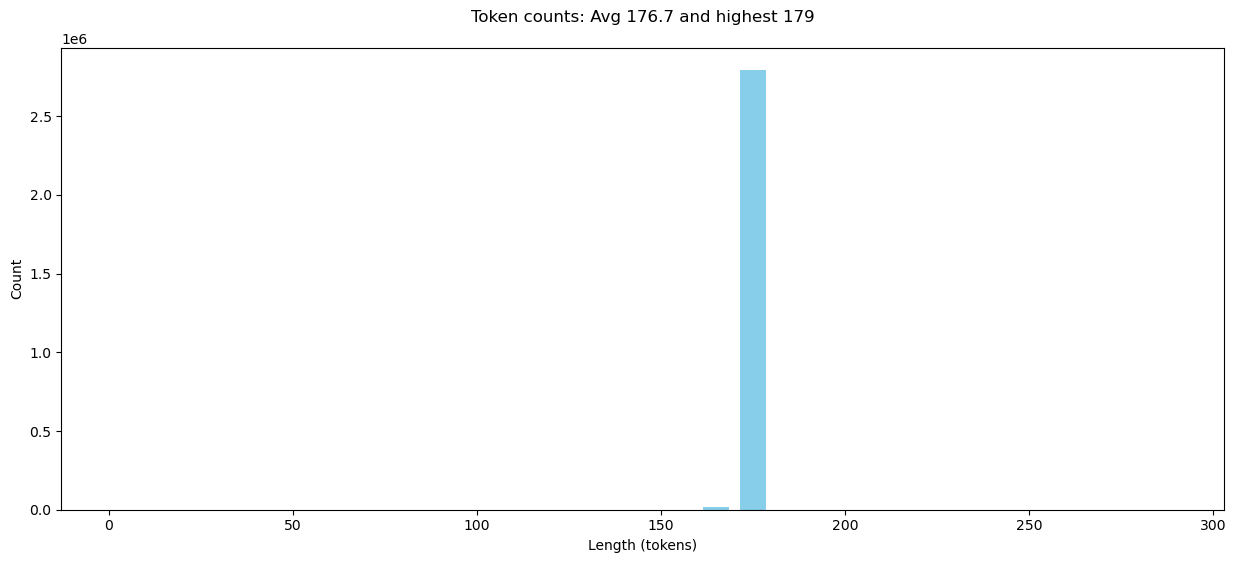

In [50]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

**There are sooooo many outliers!! Dataset is dominated by cheap items!**

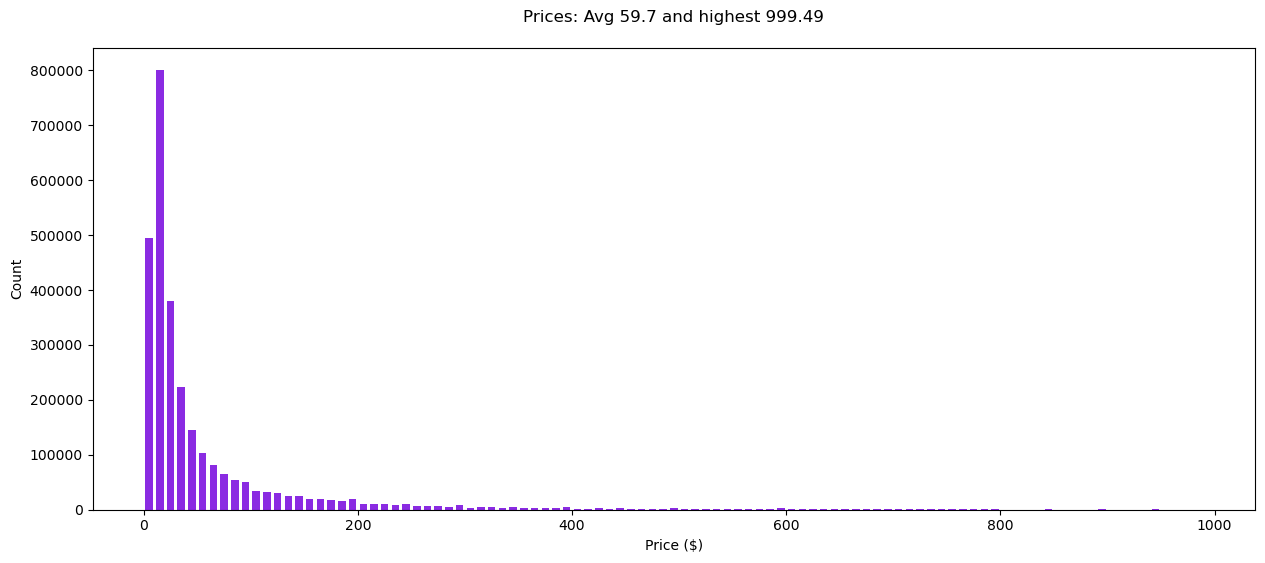

In [51]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

In [54]:
from collections import Counter
category_counts = Counter()

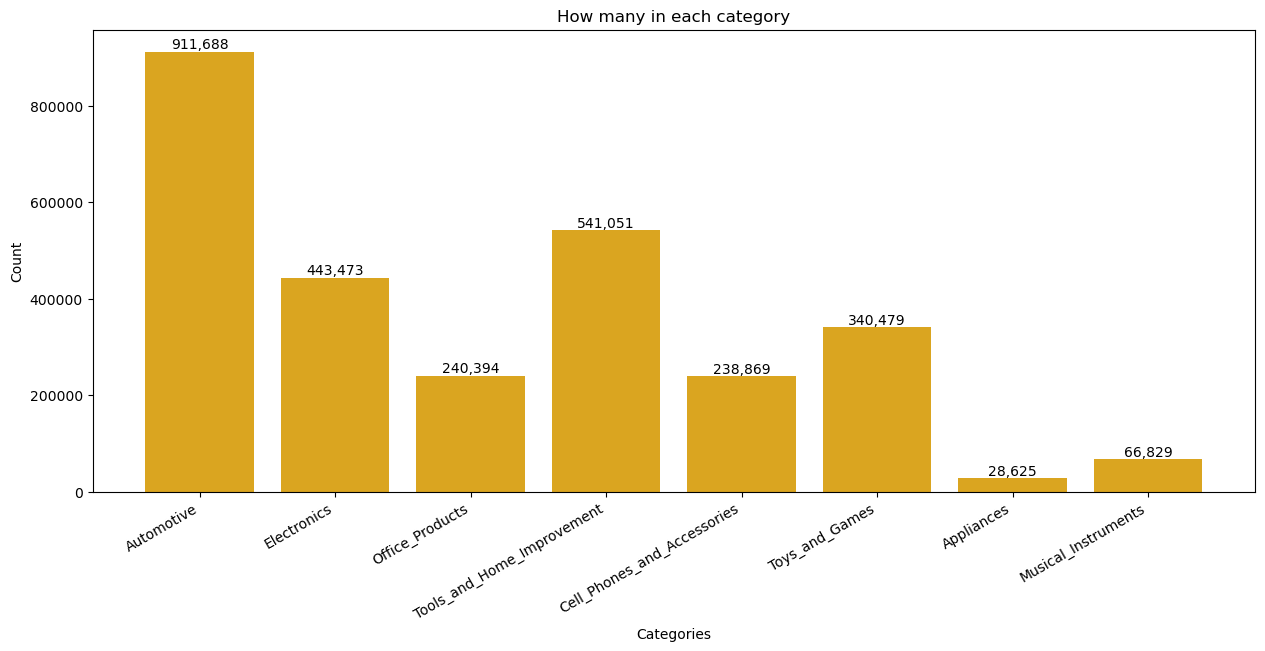

In [55]:
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

### **EDA shows unbalance -- Now, Create a balanced dataset for LLM training!!**

slots 是一个字典，键是价格（整数），值是该价格的 Item 列表

In [58]:
from collections import defaultdict

In [59]:
slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

**控制数据量，优先选择高价产品（≥ 240），低价产品加权抽样，偏向非 Automotive 类别**

In [64]:
import numpy as np
import random

In [65]:
np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        # 从一个索引集合中随机选择 1200 个不重复的索引，并根据权重 weights 分配概率
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 408,635 items in the sample


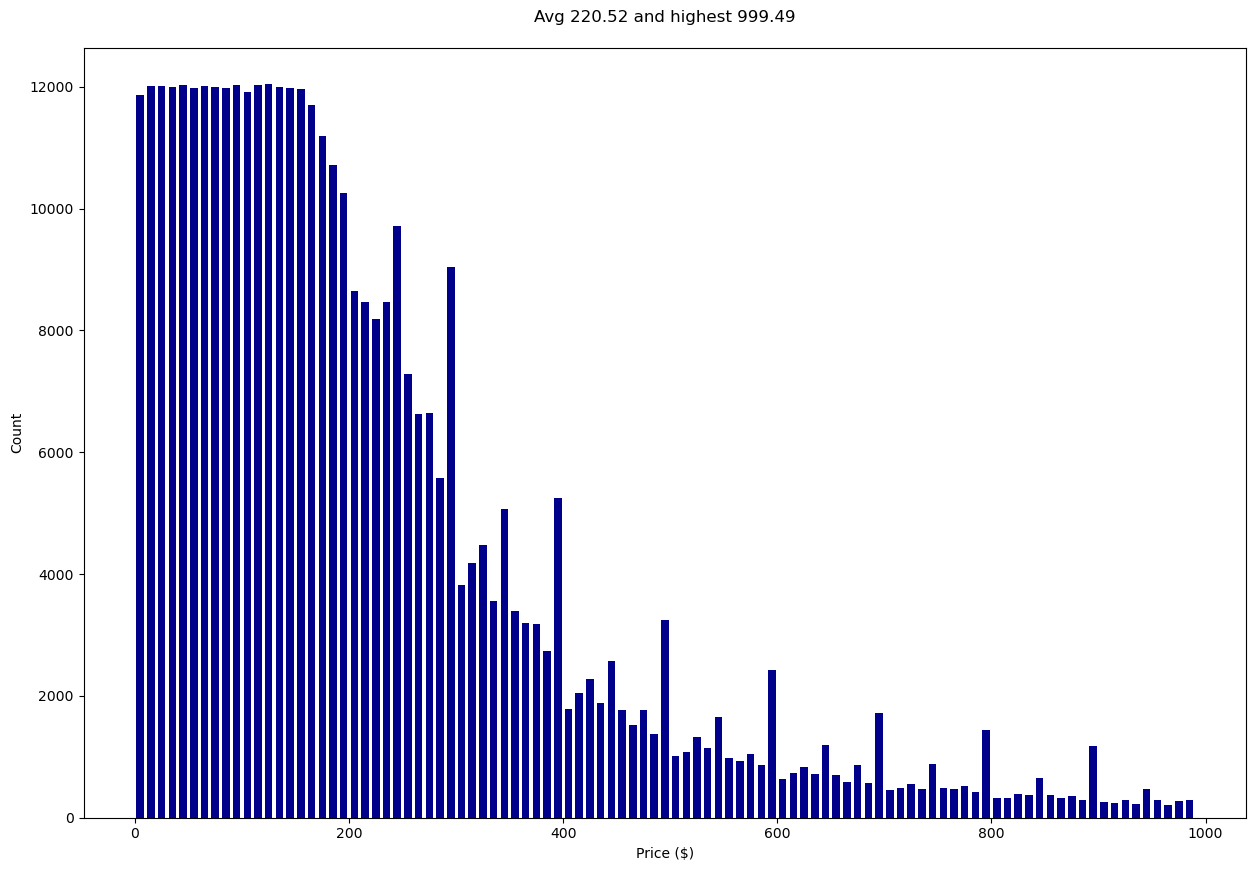

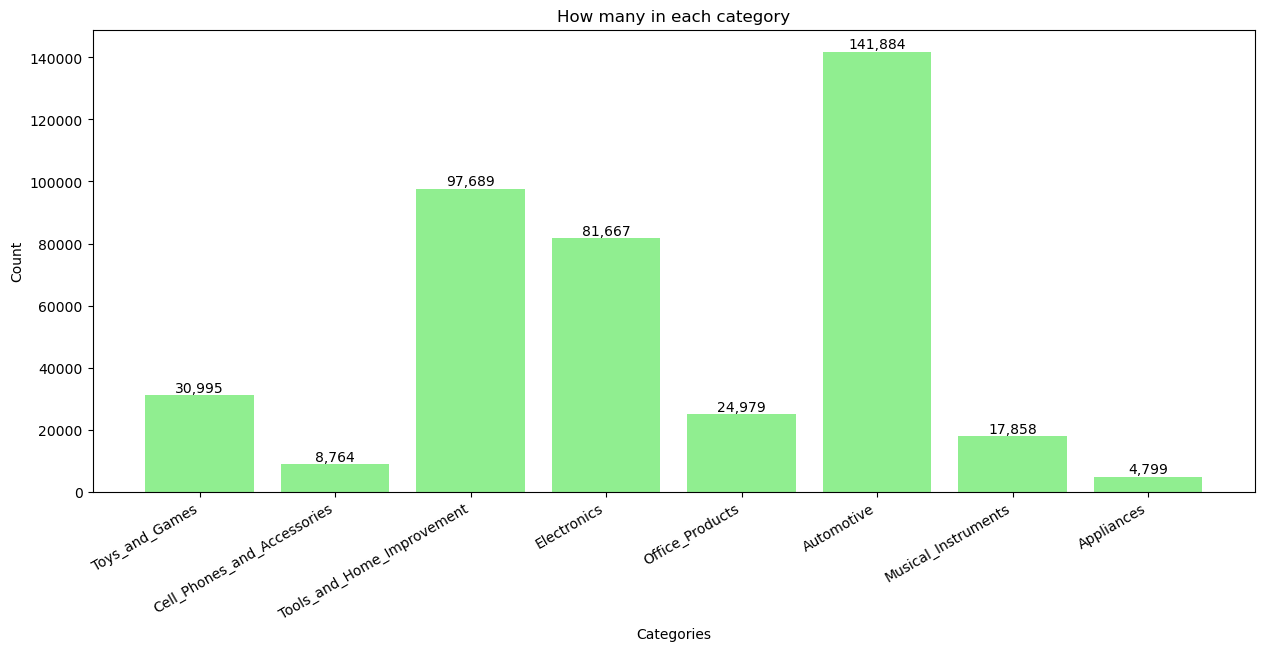

In [66]:
prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

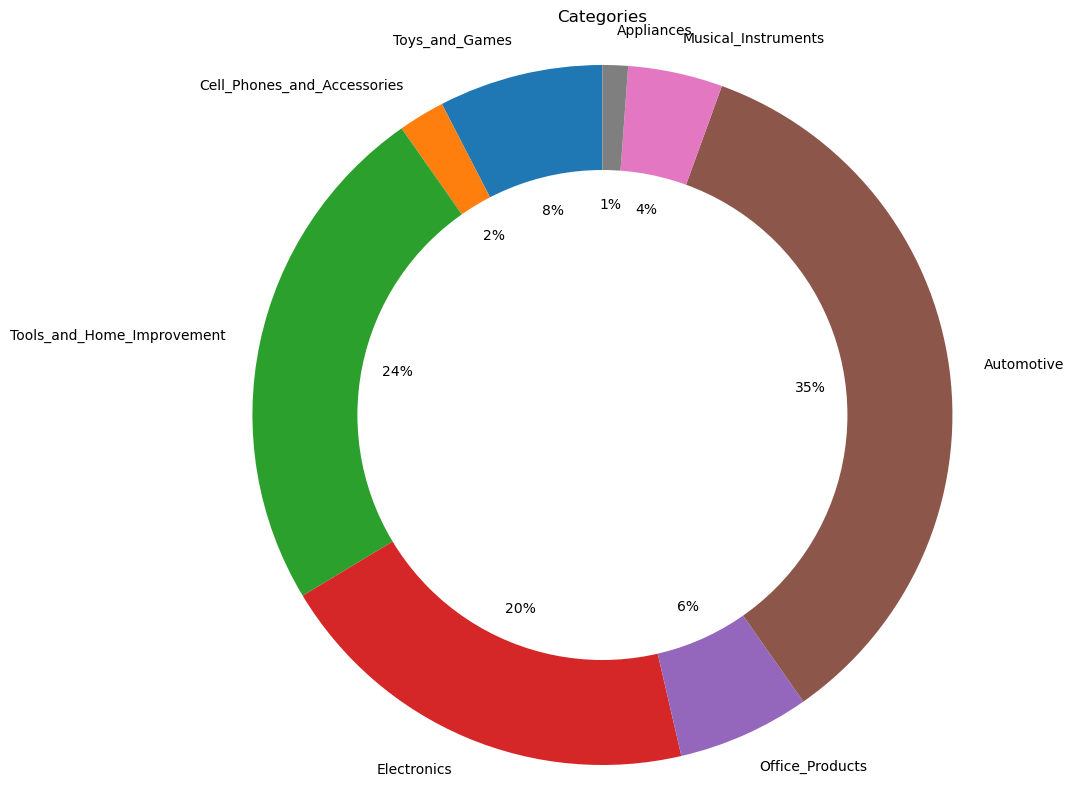

In [67]:
# Automotive still in the lead, but improved somewhat
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

### **Let's do some final checks & Sava file**

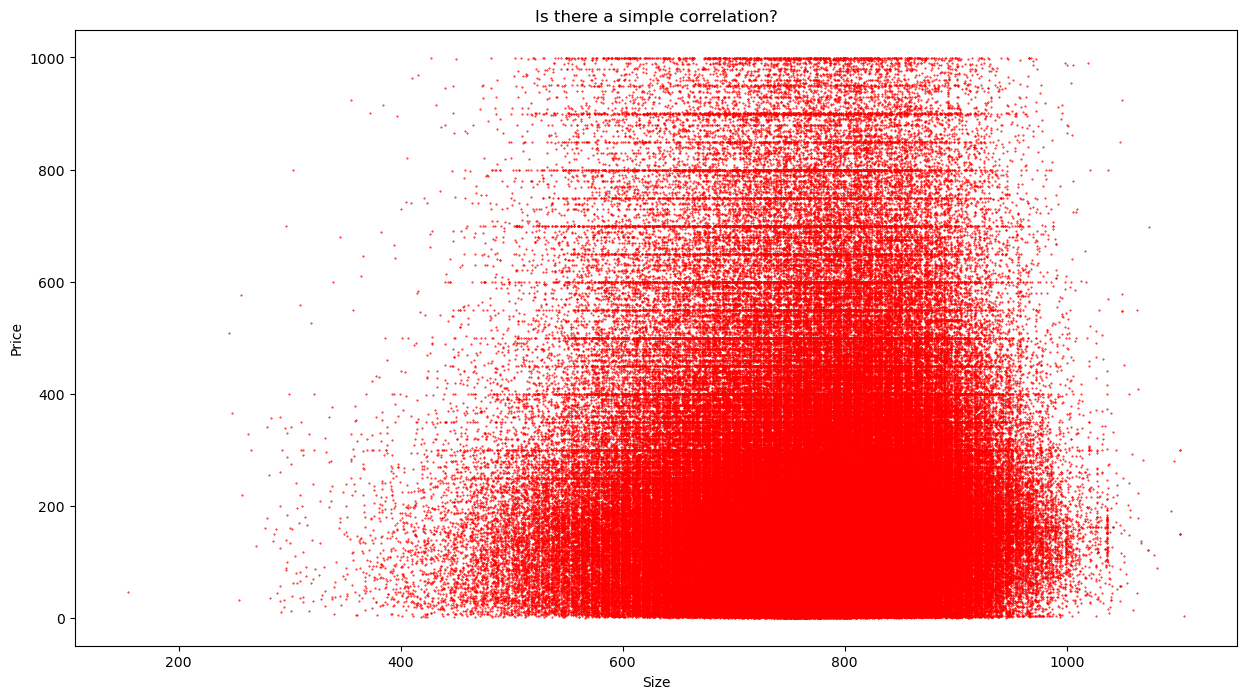

In [68]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [69]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [70]:
report(sample[398000])

How much does this cost to the nearest dollar?

MonoRS Coilovers Lowering Kit Made For Scion FRS Fully Adjustable, Set of 4
MonoRS Coilover damper kit by Godspeed Project are intermediate suspension upgrade setup for daily and Sunday club racing. Lowering your car with improved springs over factory and paired with Mono-tubo shocks with valving that allows 32 levels of rebound adjustment to improve handling without sacrifice comfort. Ride height can easily be adjusted by twisting the lower mount bracket. In order to keep weight gain at the minimum, most of attachments and accessories are CNC machined from billet aluminum. Koyo bearings are used when camber plate top mount is applicable depends on car models. To assure that our customers are getting high quality products, MonoRS coilovers are covered by 12 months limited warranty by the manufacturer from

Price is $765.00
[279, 14290, 505, 271, 7117, 374, 400, 22240, 13, 410]
[' the', ' manufacturer', ' from', '\n\n', 'Price', ' is', ' $

**It's time to break down our data into a training, test and validation dataset**

In [71]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 400,000 items and test set of 2,000 items


In [72]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [73]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $


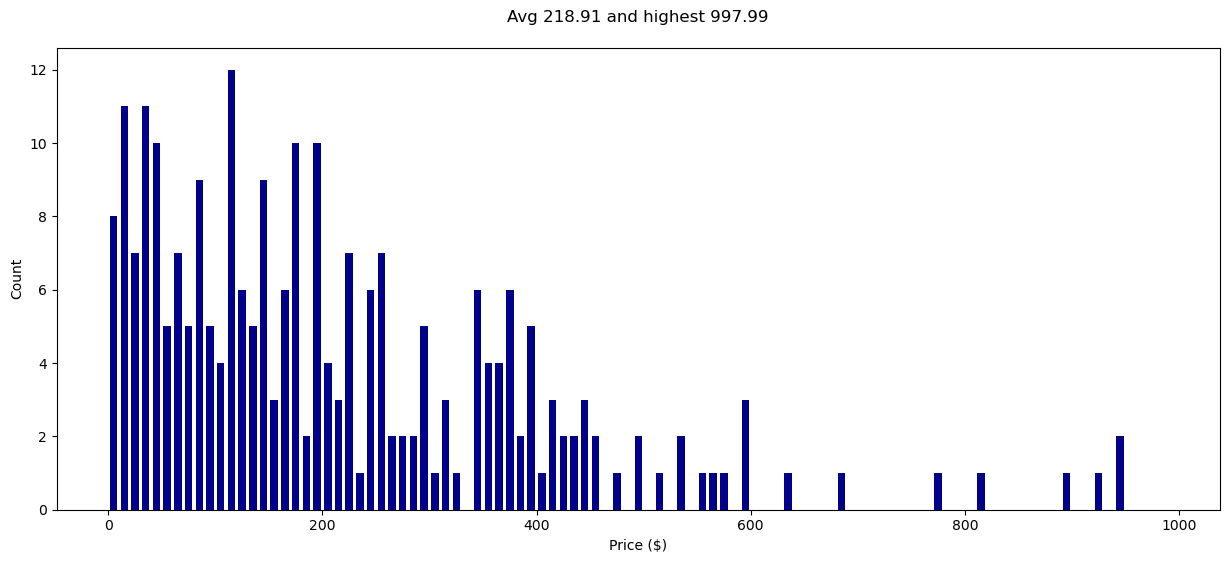

In [74]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

**Finally - upload your brand new dataset**

In [75]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [76]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [77]:
HF_USER = "Zekin77"
DATASET_NAME = f"{HF_USER}/pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/400 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Zekin77/pricer-data/commit/df8e81ba4314a942cd33052116a6b0c2e39deb5e', commit_message='Upload dataset', commit_description='', oid='df8e81ba4314a942cd33052116a6b0c2e39deb5e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Zekin77/pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Zekin77/pricer-data'), pr_revision=None, pr_num=None)

In [79]:
import pickle

In [80]:
with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)

## **3️⃣Step 3 : Pre Machie Learning**

### **Tons of Import & Load pickle File**

In [32]:
# imports

import os 
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI

In [33]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [34]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [35]:
# NLP related imports

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [36]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

**在终端中打印彩色文本的常量，提升可读性或突出信息**

In [37]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [38]:
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
deepseek_api_key = os.getenv('DEEPSEEK_API_KEY')
hf_api_key = os.getenv('HF-Write')
oai_client = OpenAI()
ds_client = OpenAI(api_key=deepseek_api_key, base_url="https://api.deepseek.com")
login(hf_api_key, add_to_git_credential=True)

In [39]:
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
deepseek_api_key = os.getenv('DEEPSEEK_API_KEY')
hf_api_key = os.getenv('HF-Write')

In [40]:
oai_client = OpenAI()
ds_client = OpenAI(api_key=deepseek_api_key, base_url="https://api.deepseek.com")

In [41]:
login(hf_api_key, add_to_git_credential=True)

**Loading the pkl files**

In [42]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

**Check Data**

In [43]:
# Remind ourselves the training prompt

print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [44]:
# Remind a test prompt

print(train[0].price)

226.95


In [47]:
print(train[0].test_prompt())

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $


### **Unveiling a mighty script that we will use a lot**

A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

**模型：**
```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`Tester.test(my_prediction_function)`

To evaluate your model.

In [48]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        # 如果 title 是 None，self.title 会被设置为函数名的格式化版本（如 "My Prediction Function"）
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        # 如果绝对误差小于 40 或 相对误差小于 20%
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        # 绝对误差
        error = abs(guess - truth)
        # 对数误差
        log_error = math.log(truth+1) - math.log(guess+1)
        # 平方对数误差
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        # 计算真实值和预测值中的最大值，用于设置图表的范围
        max_val = max(max(self.truths), max(self.guesses))
        # 绘制一条对角线，作为散点图的参考线
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    # @classmethod 是一个内置装饰器，告诉 Python test 方法是类方法
    # 类方法接收类（cls）作为第一个参数，而不是实例（self）
    # 在类方法中，Python 自动将类本身作为第一个参数（命名为 cls 是惯例）
    # 作用：允许通过类名直接调用方法（如 Tester.test(function)），而无需先创建实例
    @classmethod
    def test(cls, function):
        cls(function).run()

**An Simple Example**

In [49]:
def random_pricer(item):
    # 生成 1 到 999 之间的随机整数
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $374.41 Error: $280.59 SLE: 0.31 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $115.00 Truth: $225.11 Error: $110.11 SLE: 0.45 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $26.00 Truth: $61.68 Error: $35.68 SLE: 0.71 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $760.00 Truth: $599.99 Error: $160.01 SLE: 0.06 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $282.00 Truth: $16.99 Error: $265.01 SLE: 7.59 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $251.00 Truth: $31.99 Error: $219.01 SLE: 4.13 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $229.00 Truth: $101.79 Error: $127.21 SLE: 0.65 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $143.00 Truth: $289.00 Error: $146.00 SLE: 0.49 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $755.00 Truth: $635.86 Error: $119.14 SLE: 0.03 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $105.00 Truth: $65.99 Error: $39.01 S

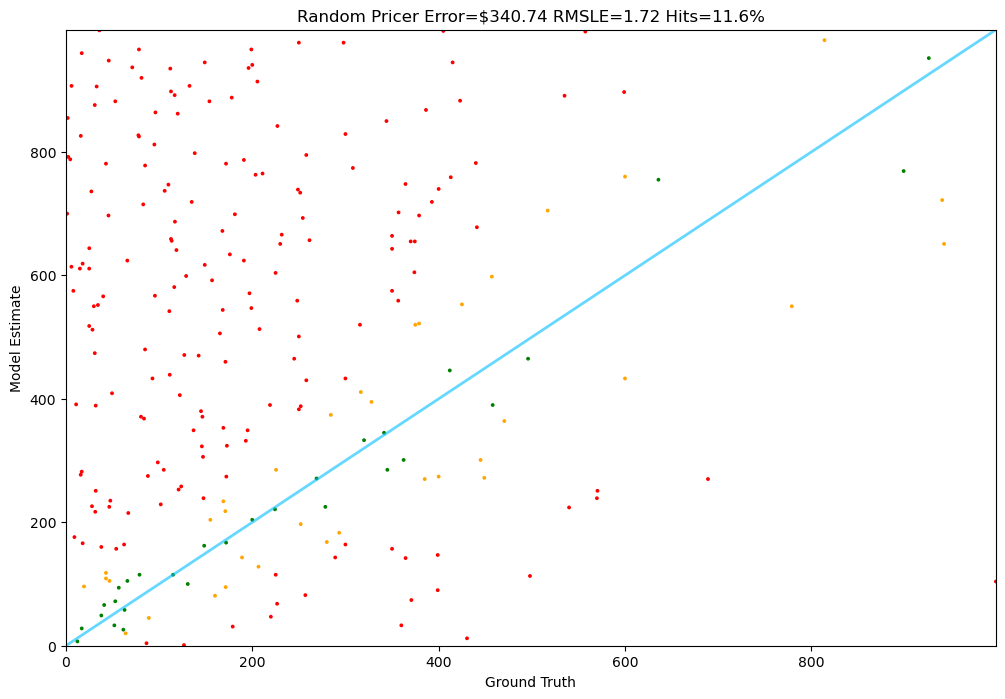

In [50]:
# Set the random seed
random.seed(42)

# Run our TestRunner
Tester.test(random_pricer)

## **4️⃣Step 4 : Feature Engineering**

**Be aware that ```train``` is a JSON instead of a python dictionary**

它是纯文本（字符串），不能直接像 Python 字典那样访问键值（data["Brand"] 会报错）

In [52]:
pprint(train[0].details)

('{"Brand": "Delphi", "Fit Type": "Vehicle Specific Fit", "Item Dimensions '
 'LxWxH": "19.7 x 7.7 x 5.1 inches", "Item Weight": "2.2 Pounds", "Auto Part '
 'Position": "Unknown", "Operation Mode": "Mechanical", "Manufacturer": '
 '"Delphi", "Model": "FUEL PUMP", "Product Dimensions": "19.7 x 7.7 x 5.1 '
 'inches", "Country of Origin": "USA", "Item model number": "FG0166", "Is '
 'Discontinued By Manufacturer": "No", "Exterior": "Painted", "Manufacturer '
 'Part Number": "FG0166", "OEM Part Number": "25326856, 89060639, A30416, '
 'E4061R, MU242", "Best Sellers Rank": {"Automotive": 913571, "Automotive '
 'Replacement Electric Fuel Pumps": 6568}, "Domestic Shipping": "Item can be '
 'shipped within U.S.", "International Shipping": "This item is not eligible '
 'for international shipping.  Learn More", "Date First Available": "August 9, '
 '2006"}')


**Convert it into Python Dictionary**

In [54]:
for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

In [61]:
train[0].features

{'Brand': 'Delphi',
 'Fit Type': 'Vehicle Specific Fit',
 'Item Dimensions LxWxH': '19.7 x 7.7 x 5.1 inches',
 'Item Weight': '2.2 Pounds',
 'Auto Part Position': 'Unknown',
 'Operation Mode': 'Mechanical',
 'Manufacturer': 'Delphi',
 'Model': 'FUEL PUMP',
 'Product Dimensions': '19.7 x 7.7 x 5.1 inches',
 'Country of Origin': 'USA',
 'Item model number': 'FG0166',
 'Is Discontinued By Manufacturer': 'No',
 'Exterior': 'Painted',
 'Manufacturer Part Number': 'FG0166',
 'OEM Part Number': '25326856, 89060639, A30416, E4061R, MU242',
 'Best Sellers Rank': {'Automotive': 913571,
  'Automotive Replacement Electric Fuel Pumps': 6568},
 'Domestic Shipping': 'Item can be shipped within U.S.',
 'International Shipping': 'This item is not eligible for international shipping.  Learn More',
 'Date First Available': 'August 9, 2006'}

In [62]:
train[0].features.keys()

dict_keys(['Brand', 'Fit Type', 'Item Dimensions LxWxH', 'Item Weight', 'Auto Part Position', 'Operation Mode', 'Manufacturer', 'Model', 'Product Dimensions', 'Country of Origin', 'Item model number', 'Is Discontinued By Manufacturer', 'Exterior', 'Manufacturer Part Number', 'OEM Part Number', 'Best Sellers Rank', 'Domestic Shipping', 'International Shipping', 'Date First Available'])

In [87]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 360062),
 ('Item Weight', 350444),
 ('Manufacturer', 349357),
 ('Brand', 340323),
 ('Best Sellers Rank', 330473),
 ('Item model number', 277573),
 ('Product Dimensions', 262400),
 ('Color', 183794),
 ('Is Discontinued By Manufacturer', 169828),
 ('Manufacturer Part Number', 145092),
 ('Material', 137447),
 ('Country of Origin', 121451),
 ('Style', 77639),
 ('Special Feature', 74709),
 ('Part Number', 74529),
 ('Batteries Required?', 73595),
 ('Package Dimensions', 72900),
 ('Item Dimensions LxWxH', 71385),
 ('Included Components', 67509),
 ('Model', 65144),
 ('Size', 58233),
 ('Item Package Quantity', 58149),
 ('Batteries Included?', 56779),
 ('OEM Part Number', 56062),
 ('Special Features', 53740),
 ('Exterior', 50566),
 ('Power Source', 50256),
 ('Vehicle Service Type', 49420),
 ('Finish Type', 46262),
 ('Voltage', 46036),
 ('Mounting Type', 38043),
 ('Model Name', 37524),
 ('Shape', 34816),
 ('Finish', 31901),
 ('Number of Items', 31871),
 ('Connectivity Te

In [92]:
train[80].features.get('Item Weight')

'13.32 pounds'

**As you can see, there are sooooo many units!!**

In [96]:
unit_counter = Counter()
for item in train:
    weight = item.features.get('Item Weight')
    if weight:
        unit = weight.split(" ")[-1]
        unit_counter[unit] += 1
unit_counter

Counter({'pounds': 219398,
         'ounces': 67265,
         'Pounds': 49512,
         'Kilograms': 5704,
         'Ounces': 4513,
         'Grams': 4043,
         'Milligrams': 9})

In [98]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(item):
    # 不能改成.features['Item Weight']，因为get方法在缺失值时不报错（返回None）
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

**What about the items don't have weight? -- Use Mean Value!!**

In [99]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [100]:
average_weight = sum(weights)/len(weights)
average_weight

13.57055237029551

**对没有Item Weight的Item用均值填充**

In [101]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

**Dealing with another feature -- "Best Sellers Rank"**

**As you can see, one item may have multiple Ranks, let's use the average rank!**

In [106]:
ranks = train[0].features["Best Sellers Rank"].values()
print(ranks)
print(sum(ranks))
print(len(ranks))

dict_values([913571, 6568])
920139
2


In [108]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [109]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

380638.258828069

**对没有Best Sellers Rank的Item用均值填充**

In [110]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

**返回test_prompt的长度**

In [123]:
def get_text_length(item):
    return len(item.test_prompt())

**Look at most common 40 brands**

In [124]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

[('HP', 5500),
 ('Power Stop', 3594),
 ('Dell', 3254),
 ('Detroit Axle', 2734),
 ('Lenovo', 2441),
 ('Dorman', 2116),
 ('SAMSUNG', 1772),
 ('BUYAUTOPARTS!', 1715),
 ('ACDelco', 1609),
 ('Evan Fischer', 1415),
 ('ASUS', 1387),
 ('Sony', 1282),
 ('Canon', 1201),
 ('Callahan BRAKE PARTS', 1154),
 ('Kohler', 1152),
 ('CURT', 1120),
 ('R1 Concepts', 1054),
 ('Rareelectrical', 966),
 ('Coverking', 941),
 ('Garage-Pro', 888),
 ('Kingston Brass', 852),
 ('Spectra Premium', 834),
 ('Moen', 829),
 ('Auto Dynasty', 824),
 ('WeatherTech', 822),
 ('DELTA FAUCET', 811),
 ('Generic', 793),
 ('Apple', 783),
 ('Cardone', 765),
 ('APS', 763),
 ('K&N', 758),
 ('GM', 743),
 ('Walker', 732),
 ('EBC Brakes', 717),
 ('AKKON', 646),
 ('SPEC-D TUNING', 626),
 ('TYC', 626),
 ('Covercraft', 618),
 ('Intel', 610),
 ('A-Premium', 607)]

In [125]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    # in语句返回的是True、False
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

**Get all the features togather**

**Just remember, we only return average value but didn't put into the dict**

In [126]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [127]:
get_features(train[0])

{'weight': 2.2,
 'rank': 460069.5,
 'text_length': 748,
 'is_top_electronics_brand': 0}

**The code above means : We only choose 4 features in feature enginnering!!!!**

## **5️⃣Step 5 : Traditional Machine Learning**

### **Convert our features into a pandas dataframe**

In [159]:
def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [160]:
train_df.head()

,weight,rank,text_length,is_top_electronics_brand,price
0,2.200000,460069.5,748,0,226.95
1,81.000000,763616.0,881,0,506.98
2,30.000000,1931.0,655,0,405.00
3,13.570552,404553.5,681,0,1.95
4,1.150000,18988.0,741,0,246.93


In [161]:
test_df.head()

,weight,rank,text_length,is_top_electronics_brand,price
0,19.300000,674674.500000,832,0,374.41
1,5.000000,496362.000000,676,0,225.11
2,1.360000,74004.000000,666,0,61.68
3,5.240000,42424.666667,789,1,599.99
4,13.570552,380638.258828,761,0,16.99


### **Linear Regression**

In [162]:
# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

**模型中各个特征的权重系数**

In [163]:
model.coef_

array([2.64232186e-01, 5.19748023e-05, 7.60932835e-03, 1.98142543e+02])

In [164]:
for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.26423218629573464
rank: 5.197480233116743e-05
text_length: 0.007609328351320393
is_top_electronics_brand: 198.1425428320713
Intercept: 182.18661987897406
Mean Squared Error: 33034.33677196799
R-squared Score: 0.09091571194865244


In [172]:
len(y_pred)

250

**Use Linear Regression for Prediction**

In [181]:
def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

In [182]:
linear_regression_pricer(test[0])

228.68333603815952

1: Guess: $228.68 Truth: $374.41 Error: $145.73 SLE: 0.24 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $214.45 Truth: $225.11 Error: $10.66 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $191.46 Truth: $61.68 Error: $129.78 SLE: 1.26 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $389.92 Truth: $599.99 Error: $210.07 SLE: 0.18 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $211.35 Truth: $16.99 Error: $194.36 SLE: 6.09 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $211.42 Truth: $31.99 Error: $179.43 SLE: 3.47 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $190.88 Truth: $101.79 Error: $89.09 SLE: 0.39 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $190.14 Truth: $289.00 Error: $98.86 SLE: 0.17 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $220.89 Truth: $635.86 Error: $414.97 SLE: 1.11 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $199.88 Truth: $65.99 Error: $133.89 S

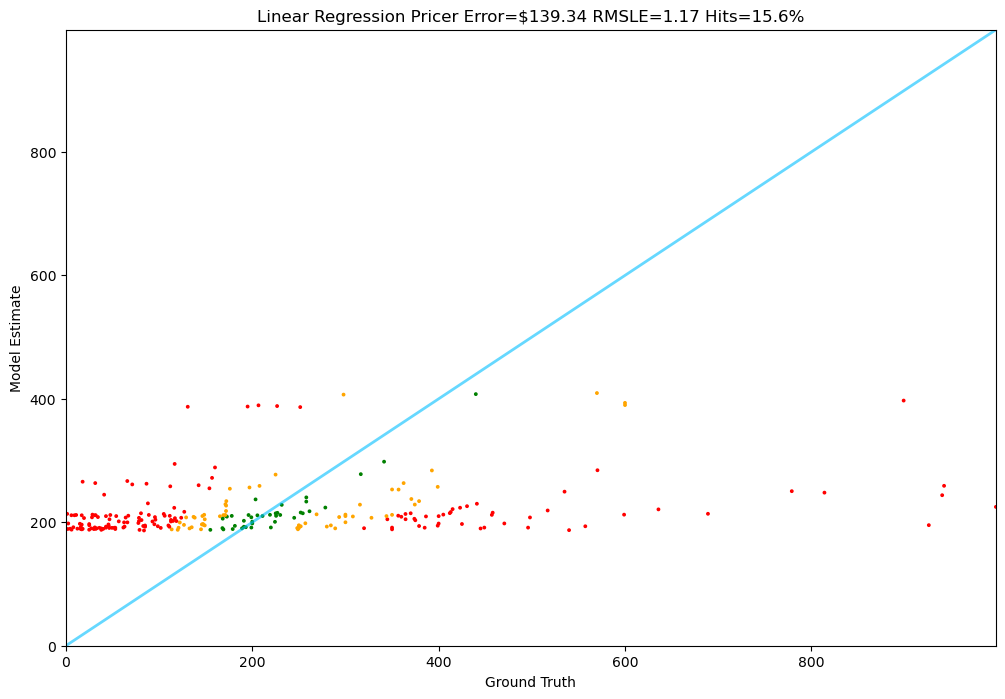

In [183]:
Tester.test(linear_regression_pricer)

### **Bags of Word（NLP）**

In [184]:
prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

**Use the CountVectorizer for a Bag of Words model**

In [185]:
np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [186]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $296.59 Truth: $374.41 Error: $77.82 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $165.14 Truth: $225.11 Error: $59.97 SLE: 0.09 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $162.26 Truth: $61.68 Error: $100.58 SLE: 0.92 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $326.15 Truth: $599.99 Error: $273.84 SLE: 0.37 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $51.69 Truth: $16.99 Error: $34.70 SLE: 1.15 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $74.06 Truth: $31.99 Error: $42.07 SLE: 0.68 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $344.83 Truth: $101.79 Error: $243.04 SLE: 1.47 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $241.39 Truth: $289.00 Error: $47.61 SLE: 0.03 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $404.57 Truth: $635.86 Error: $231.29 SLE: 0.20 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $111.13 Truth: $65.99 Error: $45.14 SLE: 0

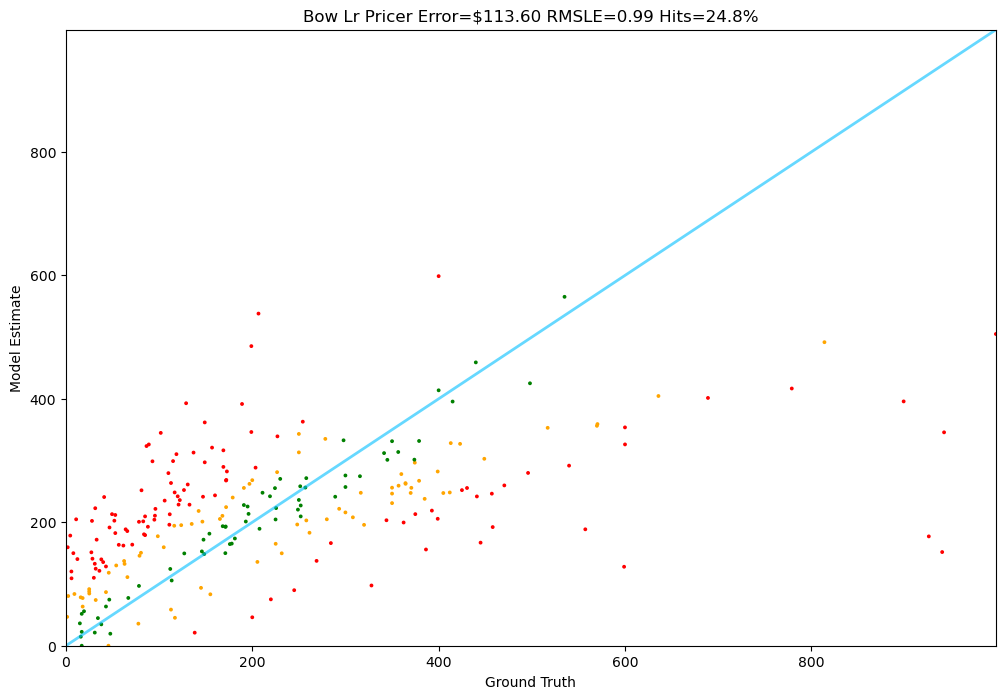

In [187]:
Tester.test(bow_lr_pricer)

### **word2vec Model**

In [188]:
np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [189]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [190]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

LinearRegression()

In [191]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $263.88 Truth: $374.41 Error: $110.53 SLE: 0.12 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $220.53 Truth: $225.11 Error: $4.58 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $133.87 Truth: $61.68 Error: $72.19 SLE: 0.59 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $353.74 Truth: $599.99 Error: $246.25 SLE: 0.28 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $109.84 Truth: $16.99 Error: $92.85 SLE: 3.31 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $291.90 Truth: $101.79 Error: $190.11 SLE: 1.10 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $264.83 Truth: $289.00 Error: $24.17 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $330.53 Truth: $635.86 Error: $305.33 SLE: 0.43 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $97.61 Truth: $65.99 Error: $31.62 SLE: 0.

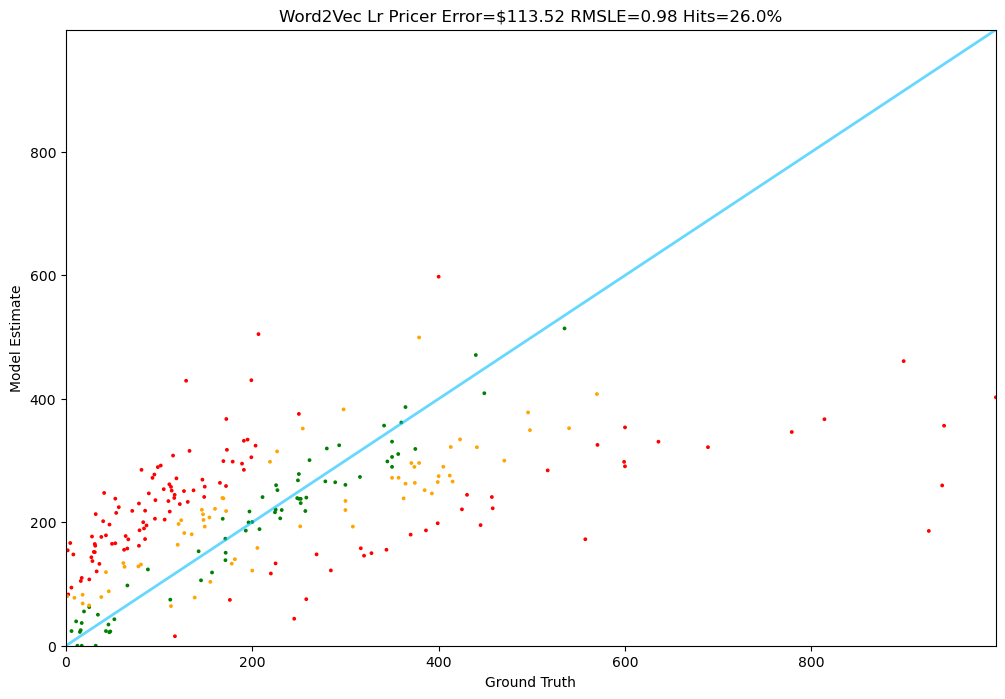

In [192]:
Tester.test(word2vec_lr_pricer)

### **Support Vector Machine**

In [193]:
np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

LinearSVR()

In [194]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $244.46 Truth: $374.41 Error: $129.95 SLE: 0.18 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $192.16 Truth: $225.11 Error: $32.95 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $117.82 Truth: $61.68 Error: $56.14 SLE: 0.41 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $298.24 Truth: $599.99 Error: $301.75 SLE: 0.49 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $84.09 Truth: $16.99 Error: $67.10 SLE: 2.41 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $232.56 Truth: $101.79 Error: $130.77 SLE: 0.67 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $197.38 Truth: $289.00 Error: $91.62 SLE: 0.14 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $273.50 Truth: $635.86 Error: $362.36 SLE: 0.71 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $90.81 Truth: $65.99 Error: $24.82 SLE: 0.

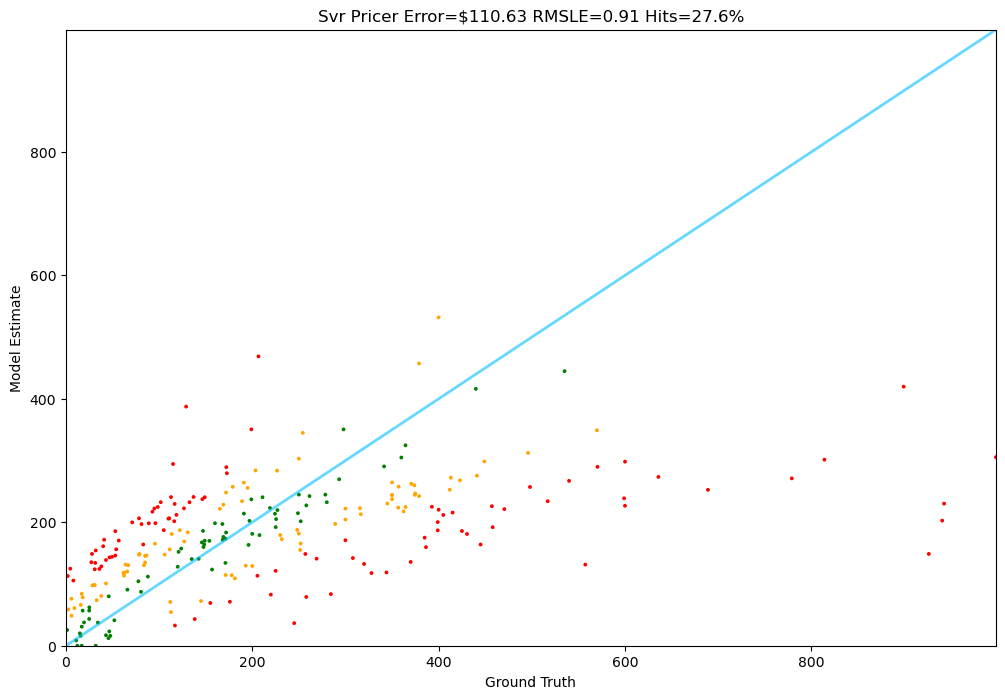

In [197]:
Tester.test(svr_pricer)

### **Random Forest**

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

In [ ]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

In [ ]:
Tester.test(random_forest_pricer)

## **6️⃣Step 6 : It's Time for Frontier Model!!!**

**2 important points:**

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

### **Before Using Frontier Model, Let's Try a Human Predictions**

In [198]:
import sys
sys.path.append(r"C:\Users\zekin\projects\llm_engineering\week6\testing.py")  # 只添加目录路径
from testing import Tester

In [199]:
import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [200]:
human_predictions = []
with open(r"C:\Users\zekin\projects\llm_engineering\week6\human_output.csv", 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [201]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $374.41 Error: $254.41 SLE: 1.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $80.00 Truth: $225.11 Error: $145.11 SLE: 1.05 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $35.00 Truth: $61.68 Error: $26.68 SLE: 0.31 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $350.00 Truth: $599.99 Error: $249.99 SLE: 0.29 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $75.00 Truth: $16.99 Error: $58.01 SLE: 2.08 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $12.00 Truth: $31.99 Error: $19.99 SLE: 0.87 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $115.00 Truth: $101.79 Error: $13.21 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $100.00 Truth: $289.00 Error: $189.00 SLE: 1.11 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $300.00 Truth: $635.86 Error: $335.86 SLE: 0.56 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $80.00 Truth: $65.99 Error: $14.01 SLE: 0.0

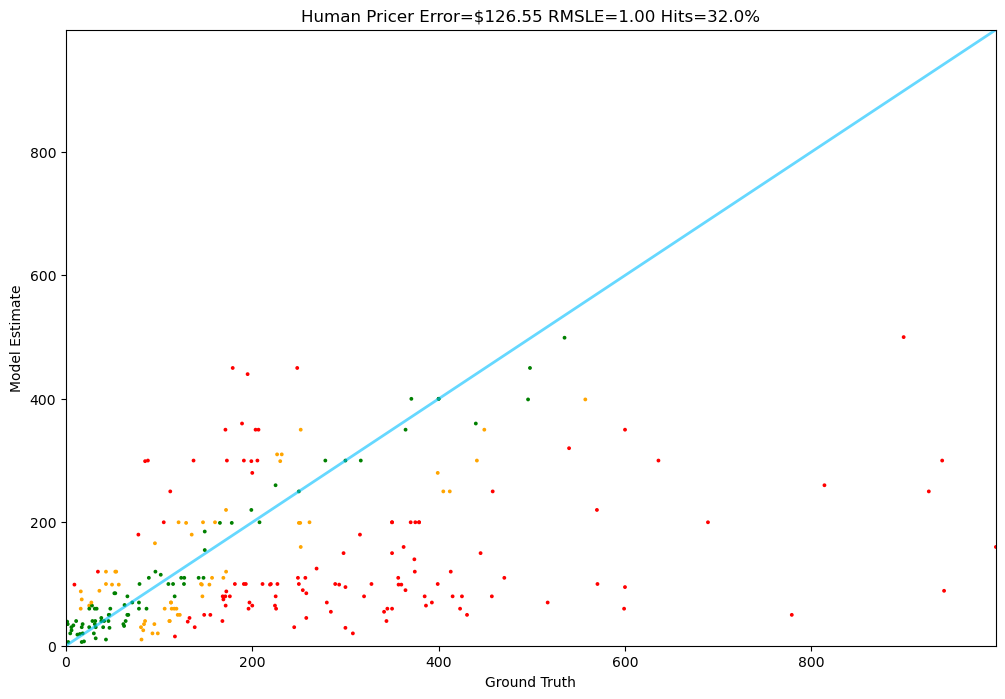

In [204]:
Tester.test(human_pricer,test)

### **Time for Frontier Model!!!!**

**Create A Prompt**

In [206]:
pprint(test[0].test_prompt())

('How much does this cost to the nearest dollar?\n'
 '\n'
 'OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT '
 '2007 2008 - BuyAutoParts NEW\n'
 "As one of the world's largest automotive parts suppliers, our parts are "
 'trusted every day by mechanics and vehicle owners worldwide. This A/C '
 'Compressor and Components Kit is manufactured and tested to the strictest OE '
 'standards for unparalleled performance. Built for trouble-free ownership and '
 '100% visually inspected and quality tested, this A/C Compressor and '
 'Components Kit is backed by our 100% satisfaction guarantee. Guaranteed '
 'Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality '
 '- tested to meet or exceed OEM specifications Engineered for superior '
 'durability, backed by industry-leading unlimited-mileage warranty Included '
 'in this K\n'
 '\n'
 'Price is $')


In [207]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [209]:
pprint(messages_for(test[0]))

[{'content': 'You estimate prices of items. Reply only with the price, no '
             'explanation',
  'role': 'system'},
 {'content': 'How much does this cost?\n'
             '\n'
             'OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & '
             'Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\n'
             "As one of the world's largest automotive parts suppliers, our "
             'parts are trusted every day by mechanics and vehicle owners '
             'worldwide. This A/C Compressor and Components Kit is '
             'manufactured and tested to the strictest OE standards for '
             'unparalleled performance. Built for trouble-free ownership and '
             '100% visually inspected and quality tested, this A/C Compressor '
             'and Components Kit is backed by our 100% satisfaction guarantee. '
             'Guaranteed Exact Fit for easy installation 100% BRAND NEW, '
             'premium ISO/TS 16949 quality - tested to meet or ex

In [212]:
import re

In [213]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    # 正则表达式，用于匹配字符串 s 中的数字
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [214]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [226]:
def gpt_4o_mini(item):
    response = oai_client.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [227]:
def deepseek_v3(item):
    response = ds_client.chat.completions.create(
        model = 'deepseek-chat',
        messages=messages_for(item),
        seed = 42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [228]:
test[0].price

374.41

In [229]:
gpt_4o_mini(test[0])

180.99

In [230]:
deepseek_v3(test[0])

249.99

1: Guess: $249.99 Truth: $374.41 Error: $124.42 SLE: 0.16 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $85.99 Truth: $225.11 Error: $139.12 SLE: 0.91 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $25.99 Truth: $61.68 Error: $35.69 SLE: 0.71 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $399.99 Truth: $599.99 Error: $200.00 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $25.99 Truth: $16.99 Error: $9.00 SLE: 0.16 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $89.99 Truth: $101.79 Error: $11.80 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $299.00 Truth: $289.00 Error: $10.00 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $499.99 Truth: $635.86 Error: $135.87 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $49.99 Truth: $65.99 Error: $16.00 SLE: 0.07 I

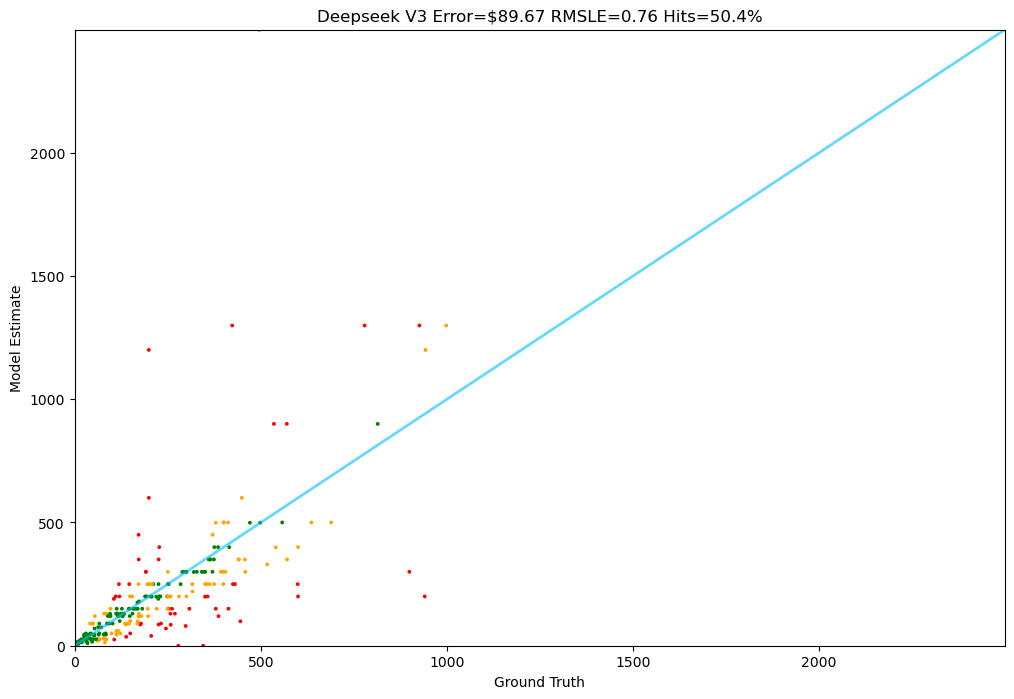

In [231]:
Tester.test(deepseek_v3, test)

## **7️⃣Step 7 : Time for Fine-Tuning Frontier Model!!!!!!!!**

The Prosess of Fine-Tunning:

**1: Create Dataset in jsonl format and upload to OpenAI**  

**2: Run Training -- train loss and validation loss should decrease**

**3: Evaluate Results**

**training_file**：训练集，提供给模型学习的数据。  
模型用它更新权重，学习数据中的模式（如价格预测）。  
比如，你的 JSONL 文件可能有 500 个样本，模型通过这些样本调整参数。  

**validation_file**：验证集，用于评估模型在训练过程中的表现。  
在训练中定期测试模型，检查是否过拟合（overfitting）或欠拟合（underfitting）。
不用于更新权重，只用于监控性能（如损失或准确率）。

**OpenAI 的 API 不要求上传测试集。你需要在 fine-tuning 完成后，自己用独立数据测试生成的模型（fine_tuned_model）**  
训练集：学生学习的课本  
验证集：老师出的练习题，检查学习效果  
测试集：期末考试，fine-tuning 不提供，你得自己准备 

In [232]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, I'm suggesting we go with 200 examples (and 1 epoch)

fine_tune_train = train[:500]
fine_tune_validation = train[500:550]

### **Step 1**

**Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI**

**Create A  Prompt**  
First let's work on a good prompt for a Frontier model  
Notice that I'm removing the " to the nearest dollar"  
When we train our own models, we'll need to make the problem as easy as possible,   
but a Frontier model needs no such simplification.  

In [233]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

**Convert the items into a list of json objects - a "jsonl" string**  
Each row represents a message in the form:  
{"messages" : [{"role": "system", "content": "You estimate prices...  

**`make_jsonl` 工作步骤**

```python
def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)  # 获取消息列表
        messages_str = json.dumps(messages)  # 转为 JSON 字符串
        result += '{"messages": ' + messages_str + '}\n'  # 包裹并加换行
    return result.strip()
```

1. **循环处理 `items`**：
   - 假设 `items` 只有一个 `item`，进入 `for` 循环。

2. **`messages = messages_for(item)`**：
   - 调用 `messages_for(item)`，返回上述 `messages` 列表。

3. **`messages_str = json.dumps(messages)`**：
   - `json.dumps` 将 `messages` 转为字符串：
     ```json
     '[{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\\n\\nDelphi FG0166 Fuel Pump Module\\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7"}, {"role": "assistant", "content": "Price is $226.95"}]'
     ```
   - 换行符等被转义为 `\n`。

4. **`result += '{"messages": ' + messages_str + '}\n'`**：
   - 将 `messages_str` 包裹在 `{"messages": ...}` 中，并加换行符：
     ```json
     {"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7"}, {"role": "assistant", "content": "Price is $226.95"}]}\n
     ```

5. **`return result.strip()`**：
   - 单次循环时，`strip()` 移除末尾 `\n`，结果为一行 JSONL：
     ```json
     {"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7"}, {"role": "assistant", "content": "Price is $226.95"}]}
     ```

#### **Continue:**

In [247]:
def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        # json.dumps() 将 Python 数据换为 JSON 字符串（换行符等被转义为 \n)
        messages_str = json.dumps(messages)
        # 逐行累加，每行是一个独立的 JSON 对象
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [248]:
messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7'},
 {'role': 'assistant', 'content': 'Price is $226.95'}]

In [249]:
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7"}, {"role": "assistant", "content": "Price is $226.95"}]}
{"messages": [{"role": "system", "content": "You estimate prices of items. 

**Convert the items into jsonl and write them to a file**

In [250]:
def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [251]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [252]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

**Pass the jonsl file to LLMs**

**PS : Must open file as 'rb'**

In [254]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = oai_client.files.create(file=f, purpose="fine-tune")

In [257]:
train_file

FileObject(id='file-Uv1ZDPWxd9kHWHBAibZU47', bytes=470870, created_at=1743318966, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [259]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = oai_client.files.create(file=f, purpose="fine-tune")

In [260]:
validation_file

FileObject(id='file-X6sYdXffvNz3Z223KAUGQG', bytes=47108, created_at=1743319779, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

### **Step 2**

I love Weights and Biases - a beautiful, free platform for monitoring training runs.  
Weights and Biases is integrated with OpenAI for fine-tuning.

First set up your weights & biases free account at:

https://wandb.ai

From the Avatar >> Settings menu, near the bottom, you can create an API key.

Then visit the OpenAI dashboard at:

https://platform.openai.com/account/organization

In the integrations section, you can add your Weights & Biases key.

**1个Fine-Tunning任务 = 1个job ID，n_epochs迭代多少次都只有一个job ID**

**1个Fine-Tunning任务需要多少步完成，由Batch Size（每次处理的条数）和n_epochs（迭代次数决定）**

**事件数是Opeani内置的，意思是大概执行多少步记录一次到日志，因此可以有多个事件ID（与Job ID不同）**

In [261]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

**在 OpenAI 云端启动一个 fine-tuning 任务，基于 gpt-4o-mini，用上传的训练和验证数据，跑 1 次迭代，集成 W&B 监控，最终生成一个带 "pricer" 后缀的模型。无需本地算力，全程云端完成。**

**返回 FineTuningJob**  

**```id```：OpenAI 为每个 fine-tuning 任务分配的标识，称为 job ID**

In [262]:
oai_client.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-ReLr5Ps0niosmITIUPMID4dt', created_at=1743321278, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-k9gayUspCUouUHMJGHT5mXUi', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-Uv1ZDPWxd9kHWHBAibZU47', validation_file='file-X6sYdXffvNz3Z223KAUGQG', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-ReLr5Ps0niosmITIUPMID4dt'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

```oai_client.fine_tuning.jobs.list(limit=1)```：

**返回最近 1 个任务的信息（如状态、模型 ID）**

**作用：快速检查最新任务概况。**

In [263]:
# 返回最近的 fine-tuning 任务列表，限制返回结果为 1 个任务（最新的那个）
oai_client.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-ReLr5Ps0niosmITIUPMID4dt', created_at=1743321278, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-k9gayUspCUouUHMJGHT5mXUi', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-Uv1ZDPWxd9kHWHBAibZU47', validation_file='file-X6sYdXffvNz3Z223KAUGQG', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-ReLr5Ps0niosmITIUPMID4dt'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix=

```job_id = oai_client.fine_tuning.jobs.list(limit=1).data[0].id```：

**从任务列表中提取最新任务的 id**

**作用：获取任务 ID 用于进一步查询**

In [265]:
job_id = oai_client.fine_tuning.jobs.list(limit=1).data[0].id

In [266]:
job_id

'ftjob-ReLr5Ps0niosmITIUPMID4dt'

```openai.fine_tuning.jobs.retrieve(job_id)``` :

**用 job_id 获取任务的详细状态**

**作用：查看任务进度（如 "running"、"succeeded"）和结果（如 fine_tuned_model ID**

In [267]:
oai_client.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-ReLr5Ps0niosmITIUPMID4dt', created_at=1743321278, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-k9gayUspCUouUHMJGHT5mXUi', result_files=[], seed=42, status='running', trained_tokens=None, training_file='file-Uv1ZDPWxd9kHWHBAibZU47', validation_file='file-X6sYdXffvNz3Z223KAUGQG', estimated_finish=1743322300, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-ReLr5Ps0niosmITIUPMID4dt'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

```oai_client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data```:

**返回任务的最近 10 个事件日志**

**作用：深入了解训练过程（如“开始”、“完成”）**

In [269]:
oai_client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-cUSePYMyeUWqnMlYHhZo21P7', created_at=1743322335, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-nOI4rhO8DjSpMWob29AuGiTz', created_at=1743322330, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-V5xrjrdykdFGgurFJhF4qx8Z', created_at=1743322270, level='info', message='Step 500/500: training loss=1.10, validation loss=1.87, full validation loss=1.13', object='fine_tuning.job.event', data={'step': 500, 'train_loss': 1.0959081649780273, 'valid_loss': 1.8747684955596924, 'total_steps': 500, 'full_valid_loss': 1.1283438968658448, 'train_mean_token_accuracy': 0.75, 'valid_mean_token_accuracy': 0.75, 'full_valid_mean_token_accuracy': 0.7975}, type='metrics'),
 FineTuningJobEvent(id='ftevent-9UrCnbW6WjWt12WY6sKZr9gc', created_at=1743322262, level='info', message='Step

Go to：https://wandb.ai/zekin-none/gpt-pricer for more intuitive understanding of the fine-tunning process

### **Step 3**

**Test our fine tuned model**

In [270]:
fine_tuned_model_name = oai_client.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [271]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:geddy:pricer:BGi41HWQ'

In [272]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [273]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [274]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [275]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [276]:
def gpt_fine_tuned(item):
    response = oai_client.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [277]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

374.41
174.77


1: Guess: $174.77 Truth: $374.41 Error: $199.64 SLE: 0.58 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $118.47 Truth: $225.11 Error: $106.64 SLE: 0.41 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $65.65 Truth: $61.68 Error: $3.97 SLE: 0.00 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $219.98 Truth: $599.99 Error: $380.01 SLE: 1.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $14.98 Truth: $16.99 Error: $2.01 SLE: 0.01 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $13.66 Truth: $31.99 Error: $18.33 SLE: 0.66 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $139.98 Truth: $101.79 Error: $38.19 SLE: 0.10 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $262.47 Truth: $289.00 Error: $26.53 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $349.99 Truth: $635.86 Error: $285.87 SLE: 0.35 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $127.99 Truth: $65.99 Error: $62.00 SLE: 0.43

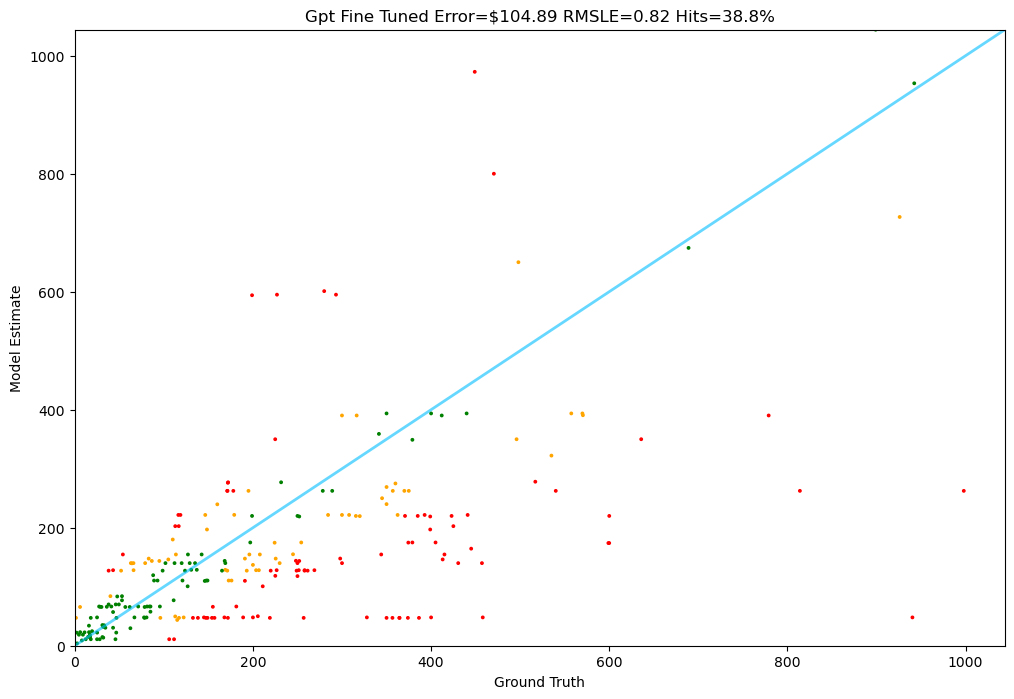

In [278]:
Tester.test(gpt_fine_tuned, test)